<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/binning_with_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#The code below is based off that of LSSTDESC/CCLX and uses that of:
#  Niko Sarcevic
#  nikolina.sarcevic@gmail.com
#  github.com/nikosarcevic
#and
#  Andrina Nicola
#  anicola[at]astro[dot]princeton[dot]edu
#  github.com/Andrina Nicola
#and
#  Elisa Chisari
#  n.e.chisari@uu.nl
#  #  github.com/elisachisari
!pip install -q condacolab
import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



#Tomographic binning of redshift distributions according to Gaussian distributions

This project focuses on analyzing galaxy data across different redshift bins to understand their spatial clustering properties.

The project begins by defining a range of redshift values and characterizing the distribution of galaxies using a Smail-type parameterization. This distribution model helps to approximate how galaxies are distributed across different redshifts, influenced by parameters like α and β.

Next, the redshift data is divided into bins defined by specific bin edges. Each bin represents a range of redshift values within which galaxies are categorized. Photometric redshift uncertainties (σ) are also considered, reflecting measurement errors in determining the precise redshift of galaxies.

Galaxy data is binned according to their Gaussian distributions. Each galaxy's contribution to the distribution curve within a bin is determined by integrating the Gaussian probability density function over the bin's range. This distributes galaxy data points across bins, accounting for uncertainties in their redshift measurements.

With normalization, the total contribution of galaxy data points across all bins sums to one.

Further analysis includes calculating angular power spectra and correlation functions for each redshift bin. These analyses provide insights into the spatial clustering of galaxies at different redshifts, and galaxy clustering evolution over cosmic time.

Overall, the project combines theoretical modeling of redshift distributions with observational data analysis techniques to analyze galaxy clustering in the universe, accounting for uncertainties in redshift measurements to hopefully derive meaningful cosmological insights.

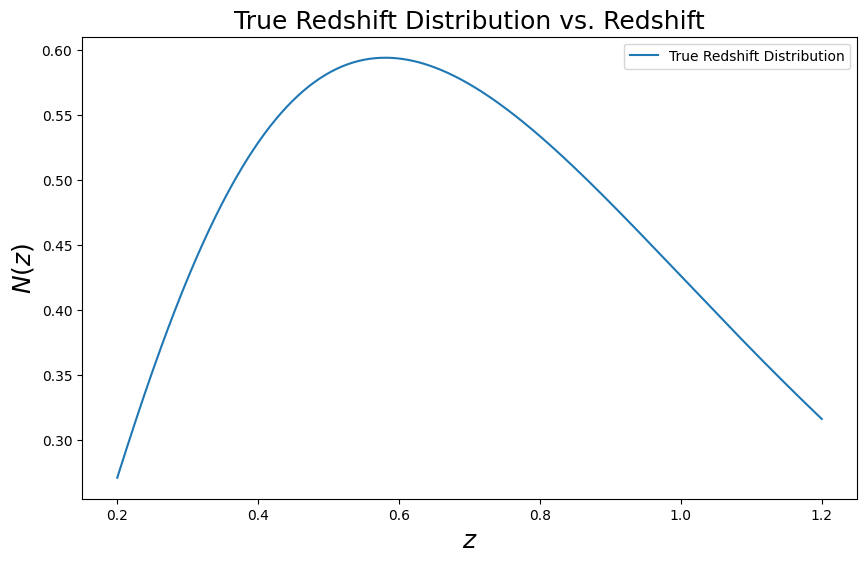

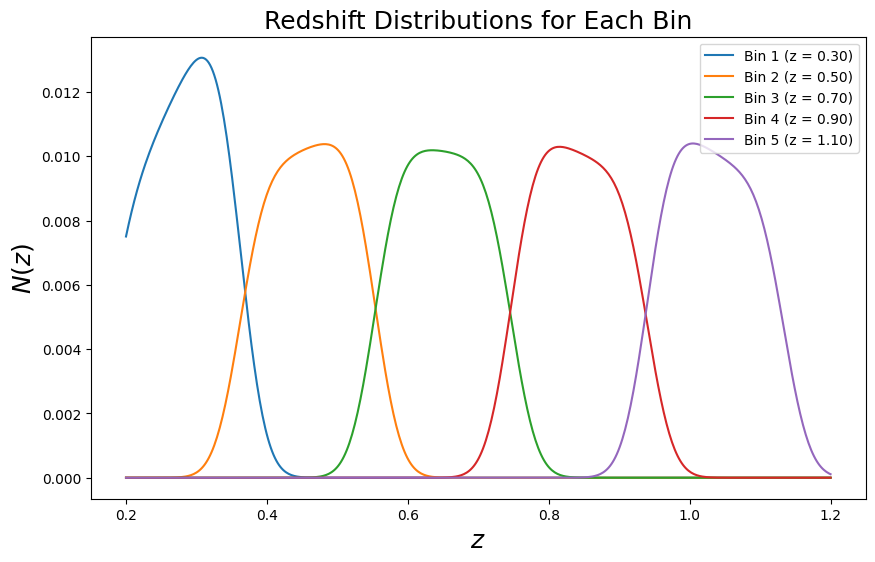

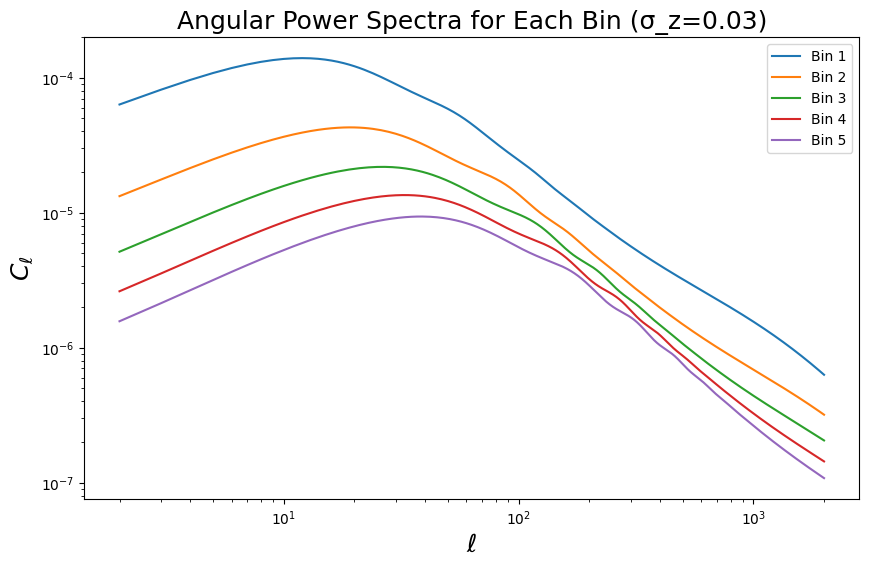

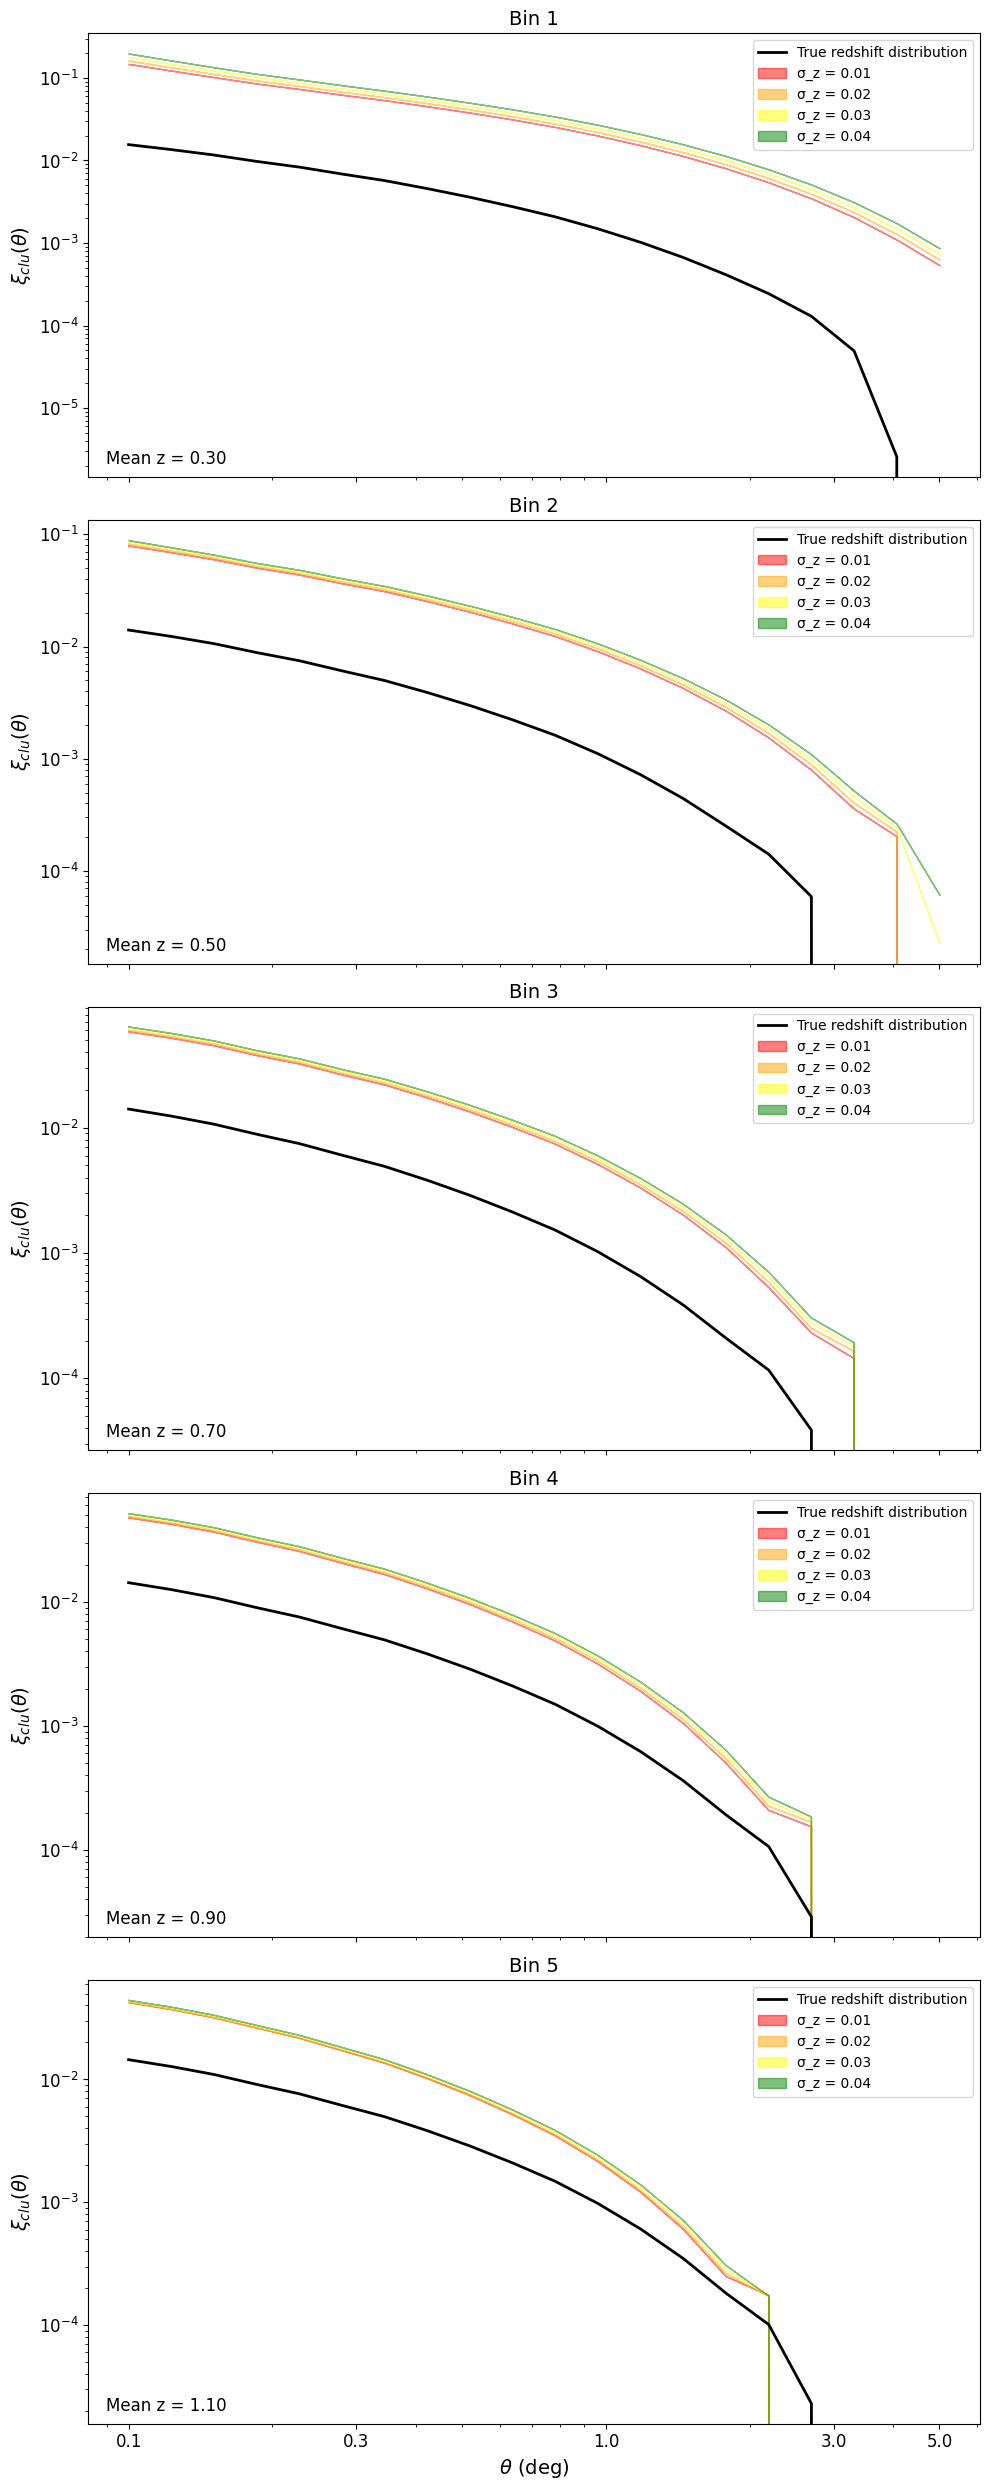

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyccl as ccl

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in self.redshift_range]
        return np.array(redshift_distribution)

class RedshiftBinning:
    def __init__(self, z, dNdz, bin_edges, sigma):
        self.z = z
        self.dNdz = dNdz
        self.bin_edges = bin_edges
        self.sigma = sigma
        self.binned_distribution = np.zeros((len(bin_edges) - 1, len(z)))

    def gaussian_contribution(self, z_i, sigma, bin_edge1, bin_edge2):
        norm_factor = 1 / (sigma * np.sqrt(2 * np.pi))
        integrand = lambda x: norm_factor * np.exp(-0.5 * ((x - z_i) / sigma)**2)
        contribution, _ = quad(integrand, bin_edge1, bin_edge2)
        return contribution

    def bin_data(self, scatter):
        for i in range(len(self.z)):
            for j in range(len(self.bin_edges) - 1):
                bin_edge1 = self.bin_edges[j]
                bin_edge2 = self.bin_edges[j + 1]
                z_i_scattered = self.z[i] + scatter[i]  # Apply scatter to the true redshift
                self.binned_distribution[j, i] = self.dNdz[i] * self.gaussian_contribution(z_i_scattered, self.sigma[i], bin_edge1, bin_edge2)

        # Normalize the binned distribution
        for j in range(len(self.bin_edges) - 1):
            self.binned_distribution[j, :] /= np.sum(self.binned_distribution[j, :])

# Define cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Define redshift range and distribution parameters
redshift_range = np.linspace(0.2, 1.2, 512)
beta = 2.0
alpha = 0.94
pivot_redshift = 0.26

# Instantiate SRDRedshiftDistributions and get redshift distribution
srd = SRDRedshiftDistributions(redshift_range)
redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)

# Plot the true redshift distribution
plt.figure(figsize=(10, 6))
plt.plot(redshift_range, redshift_distribution, label='True Redshift Distribution')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('True Redshift Distribution vs. Redshift', fontsize=18)
plt.legend()
plt.show()

# Define bin edges and sigma (uncertainty)
bin_edges = np.linspace(0.2, 1.2, 6)
sigma_z = 0.03
sigma = sigma_z * np.ones_like(redshift_range)  # Photometric redshift uncertainty

# Compute scatter as defined
scatter = sigma_z * (1 + redshift_range)

# Instantiate RedshiftBinning and bin the data
binning = RedshiftBinning(redshift_range, redshift_distribution, bin_edges, sigma)
binning.bin_data(scatter)

# Plot the redshift distributions for each bin
plt.figure(figsize=(10, 6))
for j in range(len(bin_edges) - 1):
    bin_center = 0.5 * (bin_edges[j] + bin_edges[j + 1])
    plt.plot(redshift_range, binning.binned_distribution[j], label=f'Bin {j+1} (z = {bin_center:.2f})')

plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Redshift Distributions for Each Bin', fontsize=18)
plt.legend()
plt.show()

# Create NumberCountsTracers for each bin using the binned redshift distribution
tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range
    dNdz_bin = binning.binned_distribution[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Plot angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f'Angular Power Spectra for Each Bin (σ_z={sigma_z})', fontsize=18)
plt.show()

# Compute the true redshift distribution (no photo-z uncertainty)
true_lens_redshift_distribution_dict = {}
for index, (x1, x2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    mean_z_bin = (x1 + x2) / 2
    true_lens_redshift_distribution_dict[index] = srd.smail_type_distribution(mean_z_bin, alpha, beta)

# Create the NumberCountsTracer objects for each bin with true redshift distribution
true_tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range
    dNdz = true_lens_redshift_distribution_dict[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    true_tracers.append(tracer)

# Calculate the angular power spectra for each bin (auto-correlations) with true redshift distribution
true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin with true redshift distribution
true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
for i in range(len(bin_edges) - 1):
    true_cls = true_cls_matrix[i]
    true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls, theta=theta_deg, type='NN', method='FFTLog')

# Plot the auto-correlations for different photo-z uncertainties
fig, axs = plt.subplots(len(bin_edges) - 1, 1, figsize=(10, (len(bin_edges) - 1) * 5), sharex=True)
if len(bin_edges) - 1 == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one subplot

# Define colors for plotting different photo-z uncertainties
colors = ['red', 'orange', 'yellow', 'green']

# Example sigma_values (different sigma_z for demonstration purposes)
sigma_values = [0.01, 0.02, 0.03, 0.04]

# Simulate correlations for different sigma_z values (for demonstration purposes)
correlations = []
for sigma_val in sigma_values:
    # Assuming we need to compute the correlation functions for these sigma_z values
    scatter = sigma_val * (1 + redshift_range)
    binning.bin_data(scatter)
    correlation_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
    for i in range(len(bin_edges) - 1):
        dNdz_bin = binning.binned_distribution[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(redshift_range, dNdz_bin), bias=(redshift_range, 1.5 * np.ones_like(redshift_range)))
        cls_sigma = ccl.angular_cl(cosmo, tracer, tracer, ell)
        correlation_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=cls_sigma, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(correlation_matrix)

for i in range(len(bin_edges) - 1):
    mean_z = 0.5 * (bin_edges[i] + bin_edges[i + 1])

    # Plot the true redshift distribution correlation
    xi_clu_true = true_correlations_matrix[i]
    axs[i].plot(theta_deg, xi_clu_true, color='black', label='True redshift distribution', linewidth=2)

    # Plot the shaded regions for each photo-z uncertainty using sigma_values and correlations
    for j, sigma_z in enumerate(sigma_values):
        xi_clu = correlations[j][i]

        # Calculate the upper and lower bounds
        lower_bound = np.maximum(0, xi_clu_true - (xi_clu_true - xi_clu))
        upper_bound = xi_clu_true + (xi_clu - xi_clu_true)

        # Ensure values are valid for plotting
        valid_indices = (lower_bound > 0) & (upper_bound > 0)

        # Plot the fill_between
        axs[i].fill_between(theta_deg, lower_bound, upper_bound, color=colors[j], alpha=0.5, label=f'σ_z = {sigma_z}')

    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=14)
    axs[i].set_title(f'Bin {i+1}', fontsize=14)
    axs[i].text(0.02, 0.02, f'Mean z = {mean_z:.2f}', transform=axs[i].transAxes, fontsize=12, verticalalignment='bottom')
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].legend(loc='upper right', fontsize=10)

    # Set the x-axis labels with intervals
    axs[i].set_xticks([0.1, 0.3, 1, 3, 5])
    axs[i].get_xaxis().set_major_formatter(plt.ScalarFormatter())

axs[-1].set_xlabel(r'$\theta$ (deg)', fontsize=14)
plt.tight_layout()
plt.show()


#Cross-correlation Between Different Bins
Objective: Investigate the cross-correlations between different redshift bins to understand the level of overlap and inter-bin correlation.
Method: Calculate the angular power spectra 𝐶_ℓ for cross-bin correlations (e.g., bin 1 with bin 2, bin 1 with bin 3, etc.).

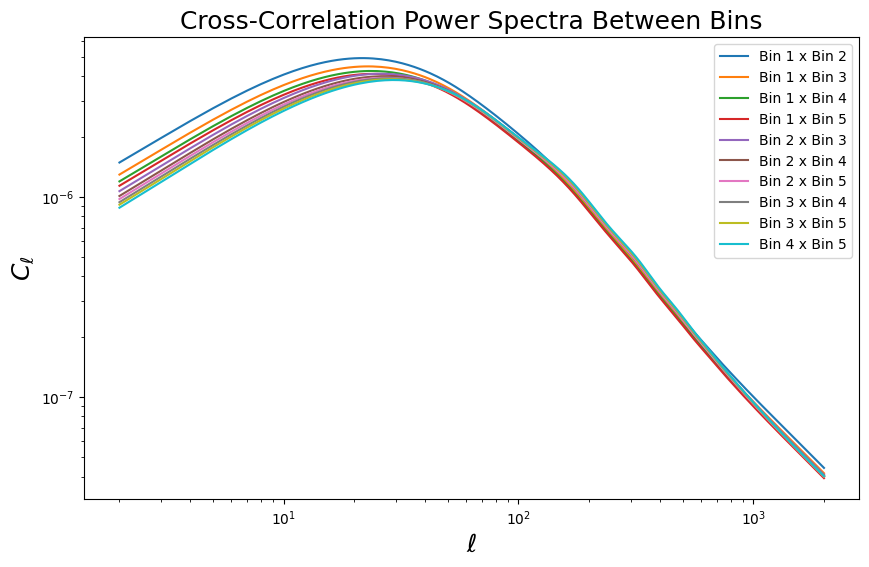

In [120]:
cross_cls_matrix = np.zeros((len(bin_edges) - 1, len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    for j in range(i + 1, len(bin_edges) - 1):
        cross_cls_matrix[i, j] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[j], ell)

# Plot cross-correlation power spectra
plt.figure(figsize=(10, 6))
for i in range(len(bin_edges) - 1):
    for j in range(i + 1, len(bin_edges) - 1):
        plt.plot(ell, cross_cls_matrix[i, j], label=f'Bin {i+1} x Bin {j+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Cross-Correlation Power Spectra Between Bins', fontsize=18)
plt.show()

#Impact of Different Sigma Values on Clustering Signals

Objective: Assess how different photometric redshift uncertainties affect the clustering signals and the derived cosmological parameters.

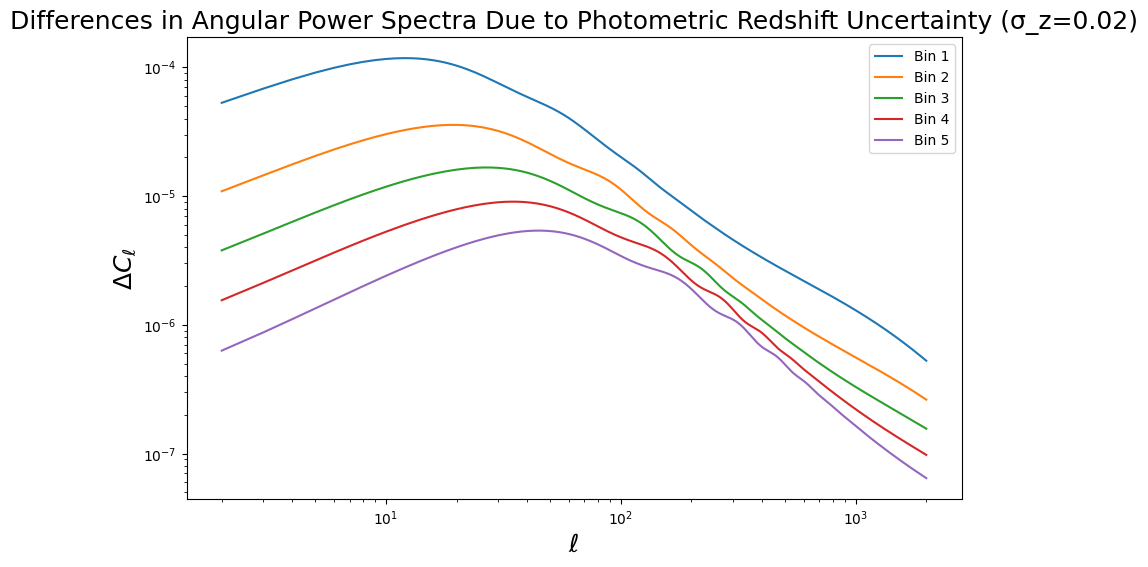

In [121]:
# Select a specific sigma_z for calculating differences
sigma_z_to_label = sigma_values[1]  # Change index as needed to select a different sigma_z

# Simulate correlations for the selected sigma_z value
scatter_selected = sigma_z_to_label * (1 + redshift_range)
binning.bin_data(scatter_selected)
selected_correlation_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))

selected_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    dNdz_bin_selected = binning.binned_distribution[i]
    tracer_selected = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(redshift_range, dNdz_bin_selected), bias=(redshift_range, 1.5 * np.ones_like(redshift_range)))
    selected_cls_matrix[i] = ccl.angular_cl(cosmo, tracer_selected, tracer_selected, ell)
    selected_correlation_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=selected_cls_matrix[i], theta=theta_deg, type='NN', method='FFTLog')

# Calculate the difference in clustering signals
delta_cl = selected_cls_matrix - true_cls_matrix

# Plot the differences in clustering signals
plt.figure(figsize=(10, 6))
for i in range(len(bin_edges) - 1):
    plt.plot(ell, delta_cl[i], label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$\\Delta C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f'Differences in Angular Power Spectra Due to Photometric Redshift Uncertainty (σ_z={sigma_z_to_label})', fontsize=18)
plt.show()



#Inferring cosmological parameters

Specifically the matter density parameter (Ω_m) and the amplitude of the matter power spectrum (σ_8), using clustering measurements.

A likelihood function allows us to quantify how well different cosmological models fit the observed data.

Prior Definitions:

Priors were defined to restrict the parameter space to roughly wikipedia ranges for Ω_𝑚 and σ_8, to ensure the MCMC sampler does not explore unrealistic values.
Constraints used:
0.29 < Omega_m < 0.32 and 0.79 < sigma8 < 0.82


In [109]:
import emcee

# Define prior functions for Omega_m and sigma8
def ln_prior(theta):
    Omega_m, sigma8 = theta
    # Flat prior within reasonable ranges
    if 0.29 < Omega_m < 0.32 and 0.79 < sigma8 < 0.82:
        return 0.0
    return -np.inf  # Return -infinity outside the prior range

# Define likelihood function
def ln_likelihood(theta):
    Omega_m, sigma8 = theta  # Parameters to be inferred

    # Define cosmology with current parameters
    cosmo = ccl.Cosmology(
        Omega_c=Omega_m - 0.045,  # Assuming Omega_b fixed at 0.045
        Omega_b=0.045,
        h=0.67,
        n_s=0.96,
        sigma8=sigma8,
        transfer_function='bbks'
    )

    # Initialize log-likelihood
    ln_likelihood_total = 0.0

    # Loop over each bin and compute likelihood contribution
    for i in range(len(bin_edges) - 1):
        # True correlation function (from true redshift distribution)
        xi_true = true_correlations_matrix[i]

        # Model correlation function (from current cosmology)
        xi_model = ccl.correlation(cosmo, ell=ell, C_ell=cls[i], theta=theta_deg, type='NN', method='FFTLog')

        # Compute chi-square or log-likelihood for this bin
        diff = xi_true - xi_model
        chi2 = np.sum((diff / xi_model)**2)

        # Add log-likelihood contribution for this bin
        ln_likelihood_total += -0.5 * chi2

    return ln_likelihood_total

# Combine prior and likelihood
def ln_prob(theta):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta)

# Initialize parameters
ndim = 2  # Number of parameters (Omega_m, sigma8)
nwalkers = 50  # Number of walkers

# Initialize walkers around a reasonable starting point
p0 = np.random.rand(nwalkers, ndim)  # Random initial positions in parameter space

# Initialize sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob)

# Run burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 100)  # Adjust burn-in steps as needed

# Reset sampler
sampler.reset()

# Run production phase
sampler.run_mcmc(pos, 1000)  # Adjust production steps as needed


State([[0.34036106 0.33461711]
 [0.71508663 0.74806779]
 [0.10368931 0.90135317]
 [0.29348402 0.81867928]
 [0.0683328  0.19665385]
 [0.1171012  0.79948837]
 [0.87466488 0.36886005]
 [0.99084441 0.01154174]
 [0.9501392  0.19752098]
 [0.30288424 0.81036886]
 [0.65745091 0.00740164]
 [0.62934779 0.48935034]
 [0.59003438 0.38607558]
 [0.29193813 0.80802206]
 [0.90139978 0.52711715]
 [0.3022021  0.80852651]
 [0.92243523 0.25857728]
 [0.6026223  0.9005766 ]
 [0.93608217 0.39036559]
 [0.03552596 0.02469552]
 [0.67869031 0.08240653]
 [0.82614531 0.12196454]
 [0.29381926 0.80047353]
 [0.64311416 0.33462142]
 [0.0707861  0.68707073]
 [0.81325104 0.3978162 ]
 [0.30416907 0.80771613]
 [0.84456825 0.77772843]
 [0.5797276  0.29497723]
 [0.31558884 0.31917407]
 [0.87594378 0.89088297]
 [0.79978738 0.68814605]
 [0.40563178 0.25567296]
 [0.88195863 0.16766405]
 [0.59933613 0.17391426]
 [0.86059163 0.93500201]
 [0.31867667 0.79505923]
 [0.16149116 0.73313192]
 [0.50424546 0.40849445]
 [0.11423965 0.1613

In [113]:
# Extract samples
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))  # Remove burn-in samples

# Compute mean and standard deviation of parameters
Omega_m_mean, sigma8_mean = np.mean(samples, axis=0)
Omega_m_std, sigma8_std = np.std(samples, axis=0)

# Compute 1-sigma (68%) confidence intervals
Omega_m_conf = np.percentile(samples[:, 0], [16, 50, 84])  # 1-sigma confidence intervals
sigma8_conf = np.percentile(samples[:, 1], [16, 50, 84])  # 1-sigma confidence intervals

print(f"Omega_m = {Omega_m_mean:.3f} +/- {Omega_m_std:.3f}")
print(f"sigma8 = {sigma8_mean:.3f} +/- {sigma8_std:.3f}")
print(f"Omega_m 1-sigma confidence interval: {Omega_m_conf[1]:.3f} +{Omega_m_conf[2]-Omega_m_conf[1]:.3f} -{Omega_m_conf[1]-Omega_m_conf[0]:.3f}")
print(f"sigma8 1-sigma confidence interval: {sigma8_conf[1]:.3f} +{sigma8_conf[2]-sigma8_conf[1]:.3f} -{sigma8_conf[1]-sigma8_conf[0]:.3f}")


Omega_m = 0.501 +/- 0.303
sigma8 = 0.459 +/- 0.291
Omega_m 1-sigma confidence interval: 0.535 +0.328 -0.421
sigma8 1-sigma confidence interval: 0.403 +0.397 -0.273
